In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# !pip install -e /home/walml/repos/zoobot_private

In [3]:
import matplotlib

In [4]:
import sklearn

In [5]:
import os
import logging
import argparse
import glob
import json
from multiprocessing import Pool

from IPython.display import display, Markdown

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib.gridspec as gridspec
import seaborn as sns
from PIL import Image

import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u

from scipy import stats, integrate
from scipy.stats import binom
import statsmodels.api as sm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, mean_squared_error, mean_absolute_error
import tensorflow as tf

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses, dirichlet_stats
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot.active_learning import acquisition_utils
from zoobot import label_metadata


In [6]:
os.chdir('/home/walml/repos/zoobot_private')

In [7]:
questions = label_metadata.decals_questions
label_cols = label_metadata.decals_label_cols
version = 'decals'

schema = losses.Schema(label_cols, questions, version=version)
schema.questions

{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}


[smooth-or-featured, indices 0 to 2, asked after None,
 disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1,
 has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4,
 bar, indices 7 to 9, asked after disk-edge-on_no, index 4,
 bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4,
 how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0,
 edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3,
 spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5,
 spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5,
 merging, indices 30 to 33, asked after None]

In [8]:

# previously shared in draft paper
# predictions_loc = 'results/temp/decals_n2_allq_m0_all.csv'
# eval_loc = 'results/temp/decals_n2_allq_m0_eval_shards/eval_df.csv'

In [9]:
eval_loc = 'results/decals_dr_full_eval_df.csv'
eval_df = pd.read_csv(eval_loc)
eval_df['local_png_loc'] = eval_df['local_png_loc'].apply(lambda x: x.replace('/data/phys-zooniverse/chri5177', '/media/walml/beta/decals'))
# eval_df doesn't include total-votes, add it
for question in schema.questions:
    eval_df[question.text + '_total-votes'] = np.array([eval_df[answer.text].values for answer in question.answers]).sum(axis=0)

In [10]:




# one model - paper
# predictions_loc = 'results/decals_dr_full_m0_eval_predictions.csv'  # .1-20
# predictions = pd.read_csv(predictions_loc)
# samples = dirichlet_stats.load_all_concentrations(eval_predictions, concentration_cols=[a.text + '_concentration' for a in schema.answers])

# one model - replication on galahad
# predictions_loc = '/home/walml/repos/zoobot/data/results/dr5_color_morphology_0.csv'  # failed
# predictions_loc = '/home/walml/repos/zoobot/data/results/dr5_greyscale_morphology_0.csv'  # failed
# predictions_loc = '/home/walml/repos/zoobot/data/results/dr5_greyscale_morphology_paper_0.csv'  # pretrained weights worked
# predictions_loc = '/home/walml/repos/zoobot/data/results/dr5_greyscale_single_morphology_0.csv'  #failed
# predictions_loc = '/home/walml/repos/zoobot/data/results/dr5_color_single_morphology_0.csv'  # failed
# predictions_loc = '/home/walml/repos/zoobot/data/results/dr5_greyscale_single_paper_morphology_0.csv'  # double-checked pretrained weights, definitely works
# predictions_loc = '/home/walml/repos/zoobot/data/results/dr5_greyscale_debug_morphology_0.csv'  # replication works again, happy days
predictions_loc = '/home/walml/repos/zoobot/data/results/dr5_color_debug_morphology_0.csv'  # replication works again, happy days

# predictions_locs = glob.glob('/home/walml/repos/zoobot/data/results/dr5_color_debug_morphology_*.csv')
# predictions_locs = glob.glob('/home/walml/repos/zoobot/data/results/dr5_greyscale_debug_morphology_*.csv') 
predictions_locs = glob.glob('/home/walml/repos/zoobot/data/results/dr5_color_dist_morphology_*.csv')
eval_predictions = []
for predictions_loc in predictions_locs:

    pred_chunk = pd.read_csv(predictions_loc)
    # print(predictions.columns.values)
    # tweak a few cols
    pred_chunk['iauname'] = pred_chunk['image_loc'].apply(lambda x: os.path.basename(x).replace('.png', ''))
    prediction_cols = [col for col in pred_chunk.columns.values if col.endswith('_pred')]
    pred_chunk = pred_chunk.rename(columns=dict(zip(prediction_cols, [col.replace('_pred', '_concentration') for col in prediction_cols])))
    eval_pred_chunk = pred_chunk[pred_chunk['iauname'].isin(eval_df['id_str'])]
    eval_predictions.append(eval_pred_chunk)

eval_predictions = pd.concat(eval_predictions, axis=0)
# add in labels
eval_predictions = pd.merge(eval_predictions, eval_df, on='iauname', how='inner')
samples = dirichlet_stats.load_all_concentrations(eval_predictions, concentration_cols=[a.text + '_concentration' for a in schema.answers])

# # several models (ensemble)
# samples = []
# predictions_locs = [f'results/decals_dr_full_m{n}_eval_predictions.csv' for n in range(3)]  # 0, 1, 2
# for predictions_loc in predictions_locs:
#     predictions = pd.read_csv(predictions_loc)
#     # filter to eval
#     eval_predictions = predictions[predictions['iauname'].isin(eval_df['id_str'])]
#     print(len(eval_predictions))
#     model_samples = dirichlet_stats.load_all_concentrations(eval_predictions, concentration_cols=[a.text + '_concentration' for a in schema.answers])
#     samples.append(model_samples)
# samples = np.concatenate(samples, axis=2)  # must be same iaunames, sorted

print(samples.shape)



(34215, 34, 1)


In [11]:
eval_predictions.head()

,image_loc,smooth-or-featured_smooth_concentration,smooth-or-featured_featured-or-disk_concentration,smooth-or-featured_artifact_concentration,disk-edge-on_yes_concentration,disk-edge-on_no_concentration,has-spiral-arms_yes_concentration,has-spiral-arms_no_concentration,bar_strong_concentration,bar_weak_concentration,...,petro_th50,petro_th90,sersic_nmgy_r,elpetro_absmag_r,active_learning_on,in_gzd_ab,local_png_loc,png_exists,file_loc,id_str
0,/share/nas/walml/galaxy_zoo/decals/dr5/png/J08...,[29.26467514038086],[15.30496597290039],[7.926961421966553],[2.690880298614502],[13.509353637695312],[2.3066246509552],[9.277851104736328],[6.099160671234131],[2.6284122467041016],...,4.050050,10.752045,144.28433,-17.005320,False,False,/media/walml/beta/decals/png_native/dr5/J081/J...,True,/data/phys-zooniverse/chri5177/png_native/dr5/...,J081628.26+243922.8
1,/share/nas/walml/galaxy_zoo/decals/dr5/png/J08...,[2.6538031101226807],[35.16917037963867],[4.398383140563965],[1.544217586517334],[98.14318084716797],[30.59093475341797],[1.4372429847717285],[1.0826834440231323],[6.530796051025391],...,10.364794,22.970627,2183.71900,-19.257286,False,True,/media/walml/beta/decals/png_native/dr5/J081/J...,True,/data/phys-zooniverse/chri5177/png_native/dr5/...,J081915.52+244733.5
2,/share/nas/walml/galaxy_zoo/decals/dr5/png/J08...,[4.948700428009033],[38.06023025512695],[3.2505109310150146],[2.7801520824432373],[53.98447036743164],[3.2259788513183594],[2.2009341716766357],[9.829585075378418],[3.4065966606140137],...,5.382372,13.294090,1859.51230,-19.943620,False,True,/media/walml/beta/decals/png_native/dr5/J081/J...,True,/data/phys-zooniverse/chri5177/png_native/dr5/...,J081847.58+243214.7
3,/share/nas/walml/galaxy_zoo/decals/dr5/png/J08...,[63.74696731567383],[14.742385864257812],[11.714091300964355],[8.741035461425781],[42.126792907714844],[2.3095312118530273],[50.95892333984375],[2.227480173110962],[9.179601669311523],...,4.883406,16.149550,1551.06970,-19.174963,False,True,/media/walml/beta/decals/png_native/dr5/J082/J...,True,/data/phys-zooniverse/chri5177/png_native/dr5/...,J082126.80+242711.0
4,/share/nas/walml/galaxy_zoo/decals/dr5/png/J08...,[3.1002674102783203],[38.158660888671875],[2.867671012878418],[5.822169303894043],[6.176462173461914],[11.922823905944824],[1.1894803047180176],[1.5265798568725586],[4.177759170532227],...,13.265611,41.275604,1745.06450,-19.297043,False,True,/media/walml/beta/decals/png_native/dr5/J083/J...,True,/data/phys-zooniverse/chri5177/png_native/dr5/...,J083300.20+260050.5


In [12]:
samples[:5, :2]

array([[[29.26467514],
        [15.30496597]],

       [[ 2.65380311],
        [35.16917038]],

       [[ 4.94870043],
        [38.06023026]],

       [[63.74696732],
        [14.74238586]],

       [[ 3.10026741],
        [38.15866089]]])

In [13]:
is_retired = eval_predictions['smooth-or-featured_total-votes'] > 34
retired = eval_predictions[is_retired]
retired['file_loc'] = retired['image_loc'].apply(lambda x: '/media/walml/beta1/decals' + x)
# retired['file_loc'] = retired['local_png_loc'].apply(lambda x: '/media/walml/beta/decals' + x.replace('/data/phys-zooniverse/chri5177', ''))
retired_samples = samples[is_retired]


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
len(retired)  # only high conf

10700

In [15]:
predicted_fractions = dirichlet_stats.dirichlet_prob_of_answers(retired_samples, schema, temperature=None)

## Loss

In [16]:
answers = [a.text for a in schema.answers]

In [17]:
answers

['smooth-or-featured_smooth',
 'smooth-or-featured_featured-or-disk',
 'smooth-or-featured_artifact',
 'disk-edge-on_yes',
 'disk-edge-on_no',
 'has-spiral-arms_yes',
 'has-spiral-arms_no',
 'bar_strong',
 'bar_weak',
 'bar_no',
 'bulge-size_dominant',
 'bulge-size_large',
 'bulge-size_moderate',
 'bulge-size_small',
 'bulge-size_none',
 'how-rounded_round',
 'how-rounded_in-between',
 'how-rounded_cigar-shaped',
 'edge-on-bulge_boxy',
 'edge-on-bulge_none',
 'edge-on-bulge_rounded',
 'spiral-winding_tight',
 'spiral-winding_medium',
 'spiral-winding_loose',
 'spiral-arm-count_1',
 'spiral-arm-count_2',
 'spiral-arm-count_3',
 'spiral-arm-count_4',
 'spiral-arm-count_more-than-4',
 'spiral-arm-count_cant-tell',
 'merging_none',
 'merging_minor-disturbance',
 'merging_major-disturbance',
 'merging_merger']

In [18]:
labels = eval_predictions[answers].values

In [19]:
labels

array([[ 7.,  2.,  0., ...,  3.,  2.,  0.],
       [ 0., 17.,  2., ...,  2.,  0.,  0.],
       [ 3., 15.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  5.,  0., ...,  2.,  1.,  0.],
       [ 4.,  1.,  0., ...,  2.,  0.,  2.],
       [ 0.,  4.,  1., ...,  2.,  2.,  0.]])

In [20]:
conc_cols = [col for col in eval_predictions if 'concentration' in col]
conc_cols

['smooth-or-featured_smooth_concentration',
 'smooth-or-featured_featured-or-disk_concentration',
 'smooth-or-featured_artifact_concentration',
 'disk-edge-on_yes_concentration',
 'disk-edge-on_no_concentration',
 'has-spiral-arms_yes_concentration',
 'has-spiral-arms_no_concentration',
 'bar_strong_concentration',
 'bar_weak_concentration',
 'bar_no_concentration',
 'bulge-size_dominant_concentration',
 'bulge-size_large_concentration',
 'bulge-size_moderate_concentration',
 'bulge-size_small_concentration',
 'bulge-size_none_concentration',
 'how-rounded_round_concentration',
 'how-rounded_in-between_concentration',
 'how-rounded_cigar-shaped_concentration',
 'edge-on-bulge_boxy_concentration',
 'edge-on-bulge_none_concentration',
 'edge-on-bulge_rounded_concentration',
 'spiral-winding_tight_concentration',
 'spiral-winding_medium_concentration',
 'spiral-winding_loose_concentration',
 'spiral-arm-count_1_concentration',
 'spiral-arm-count_2_concentration',
 'spiral-arm-count_3_conc

In [21]:
# concentrations = eval_predictions[conc_cols].values

In [22]:
# concentrations

In [23]:
# samples

In [24]:
multiquestion_loss = losses.get_multiquestion_loss(schema.question_index_groups)
loss = lambda x, y: multiquestion_loss(x, y) / batch_size  

In [25]:
samples.shape

(34215, 34, 1)

In [26]:
len(samples)

34215

In [27]:
tf_labels = tf.constant(labels)
tf_preds = tf.constant(samples.squeeze())
tf_labels.shape, tf_preds.shape

(TensorShape([34215, 34]), TensorShape([34215, 34]))

In [28]:
10 * 256 * multiquestion_loss(tf_labels, tf_preds).numpy() / len(labels)
#  color 0.9028478536738243
# greyscale 0.9040616712301955

0.11802775689459119

In [29]:
loss = losses.calculate_multiquestion_loss(labels, samples.squeeze(), schema.question_index_groups).numpy()  # this version doesn't reduce
loss.shape

(34215, 10)

In [45]:
mean_loss_by_q = loss.mean(axis=0)
rows = [{'question': question.text, 'mean_loss': l, 'channels': 'color_2x'} for question, l in zip(schema.questions, mean_loss_by_q)]
rows

[{'question': 'smooth-or-featured',
  'mean_loss': 3.011364875277798,
  'channels': 'color_2x'},
 {'question': 'disk-edge-on',
  'mean_loss': 0.6891547206449515,
  'channels': 'color_2x'},
 {'question': 'has-spiral-arms',
  'mean_loss': 0.7455253736561503,
  'channels': 'color_2x'},
 {'question': 'bar', 'mean_loss': 1.3064328655061177, 'channels': 'color_2x'},
 {'question': 'bulge-size',
  'mean_loss': 2.0668172782890806,
  'channels': 'color_2x'},
 {'question': 'how-rounded',
  'mean_loss': 1.6908017630705412,
  'channels': 'color_2x'},
 {'question': 'edge-on-bulge',
  'mean_loss': 0.49195570026476504,
  'channels': 'color_2x'},
 {'question': 'spiral-winding',
  'mean_loss': 0.9382972125740999,
  'channels': 'color_2x'},
 {'question': 'spiral-arm-count',
  'mean_loss': 1.4549831992242677,
  'channels': 'color_2x'},
 {'question': 'merging',
  'mean_loss': 3.379351485432598,
  'channels': 'color_2x'}]

In [46]:

data = pd.DataFrame(data=rows)
# data.to_csv('mean_loss_color_dist.csv', index=False)

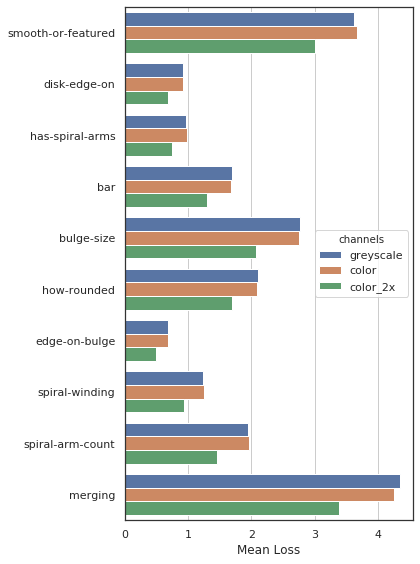

In [49]:

data_color = pd.read_csv('mean_loss_color.csv')
data_greyscale = pd.read_csv('mean_loss_greyscale.csv')
data_color_2x = pd.read_csv('mean_loss_color_dist.csv')
data = pd.concat([data_greyscale, data_color, data_color_2x])
                             
sns.set_style('whitegrid', {'axes.edgecolor': '0.2'})
sns.set_context('notebook')
# sns.set_palette(repeating_palette)
fig, ax = plt.subplots(figsize=(6, 8))
sns.barplot(data=data, y='question', x='mean_loss', hue='channels', ax=ax)
plt.xlabel('Mean Loss')
plt.ylabel('')
fig.tight_layout()
# plt.savefig('mean_deviation_bar.pdf')

# Discrete Metrics

In [33]:
def get_label(text, question):
    return clean_text(text.replace(question.text, '').title())

In [34]:
def clean_text(text):
    return text.replace('-', ' ').replace('_', '').title()

In [35]:
def filter_to_sensible(label_df, predictions, question):
#     if prev_a is not None:
#         prev_q = prev_a.question
#         prev_q_cols = [answer.text + '_fraction' for answer in prev_q.answers]
#         is_sensible = (label_df[prev_a.text + '_fraction'] / label_df[prev_q_cols].sum(axis=1)) > 0.5
#         valid_labels, valid_predictions = label_df[is_sensible], predicted_fractions[is_sensible]
#     else:
#         valid_labels, valid_predictions = label_df, predicted_fractions
    retirement = 1
    samples = np.expand_dims(predictions, axis=-1)
    expected_votes = acquisition_utils.get_expected_votes_human(label_df, question, retirement, schema, round_votes=False)
    if not isinstance(expected_votes, np.ndarray):
        expected_votes = expected_votes.numpy()  # hack, should fix properly...
#     print(expected_votes)
    is_sensible = expected_votes > 0.5
    valid_labels, valid_predictions = label_df[is_sensible], predictions[is_sensible]
    return valid_labels, valid_predictions


# def get_binary_answers(question, label_df, predicted_fractions):
#     # previous question should be valid
#     valid_labels, valid_predictions = filter_to_sensible(label_df, predicted_fractions, question)
#     cols = [answer.text + '_fraction' for answer in question.answers]
#     y_true = np.argmax(valid_labels[cols].values, axis=1)
#     y_pred = np.argmax(valid_predictions[:, question.start_index:question.end_index+1], axis=1)
#     return y_true, y_pred
    
    
# def print_metrics(question, label_df, predicted_fractions):
#     y_true, y_pred = get_binary_answers(question, label_df, predicted_fractions)
#     print('Acc: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f} <- {})'.format(
#         metrics.accuracy_score(y_true, y_pred),
#         metrics.precision_score(y_true, y_pred, average='micro'),
#         metrics.recall_score(y_true, y_pred, average='micro'),
#         metrics.f1_score(y_true, y_pred, average='micro'),
#         question.text
#     ))

# def show_confusion_matrix(question, label_df, predicted_fractions):
    
#     y_true, y_pred = get_binary_answers(question, label_df, predicted_fractions)
#     cm = confusion_matrix(y_true, y_pred)

#     labels = [get_label(a.text, question) for a in question.answers]
    
#     fig, ax = plt.subplots()
#     ax.set_title(clean_text(question.text))

#     return sns.heatmap(
#         cm,
#         annot=True,
#         cmap='Blues',
#         fmt='d',
#         xticklabels=labels,
#         yticklabels=labels,
#         cbar=False,
#         annot_kws={"size": 14},
#         ax=ax,
#         square=True,
#         robust=True
#     )


In [36]:
len(retired)

10700

In [37]:
np.sum((retired['smooth-or-featured_featured-or-disk_fraction'] * retired['disk-edge-on_no_fraction']) > 0.5)

2530

In [38]:
valid_labels, valid_predictions = filter_to_sensible(retired, predicted_fractions, schema.get_question('has-spiral-arms'))
len(valid_labels)

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


2530

In [39]:
retirement = 1  # assumed number of votes at top question
# votes for specific question, given fraction predictions and retirement (=1)
expected_votes = acquisition_utils.get_expected_votes_human(retired, question, retirement, schema, round_votes=False)  

In [40]:
def get_binary_responses(question, label_df, predicted_fractions):
    # previous question should be valid
    valid_labels, valid_predictions = filter_to_sensible(label_df, predicted_fractions, question)
    cols = [answer.text + '_fraction' for answer in question.answers]
    # most likely answer, might be less than .5 though
    y_true = np.argmax(valid_labels[cols].values, axis=1)
    y_pred = np.argmax(valid_predictions[:, question.start_index:question.end_index+1], axis=1)
    return y_true, y_pred

def print_metrics(question, label_df, predicted_fractions):
    y_true, y_pred = get_binary_responses(question, label_df, predicted_fractions)
#     print(pd.value_counts(y_pred))
#     average = 'micro'
    average = 'weighted'
    
    # human
#     print('Acc: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f} <- {}'.format(
#         sklearn.metrics.accuracy_score(y_true, y_pred),
#         sklearn.metrics.precision_score(y_true, y_pred, average=average),
#         sklearn.metrics.recall_score(y_true, y_pred, average=average),
#         sklearn.metrics.f1_score(y_true, y_pred, average=average),
#         question.text
#     ))
    # latex
    print('{} & {} & {:.4f} & {:.4f} & {:.4f} & {:.4f} \\\\'.format(
        question.text.replace('-', ' ').replace('_', ' ').title(),
        len(y_true),
        sklearn.metrics.accuracy_score(y_true, y_pred),
        sklearn.metrics.precision_score(y_true, y_pred, average=average),
        sklearn.metrics.recall_score(y_true, y_pred, average=average),
        sklearn.metrics.f1_score(y_true, y_pred, average=average)
))

    
def show_confusion_matrix(question, label_df, predicted_fractions, ax=None, blank_yticks=False, add_title=False):
    y_true, y_pred = get_binary_responses(question, label_df, predicted_fractions)
    
    labels = range(len(question.answers))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    ticklabels = [get_label(a.text, question) for a in question.answers]
    
    # manual tweaks
    for n in range(len(ticklabels)):
        if ticklabels[n] == 'Featured Or Disk':
            ticklabels[n] = 'Featured/Disk'
        elif ticklabels[n] == 'Cigar Shaped':
            ticklabels[n] = 'Cigar'
        elif ticklabels[n] == 'More Than 4':
            ticklabels[n] = '>4'
        elif ticklabels[n] == 'Cant Tell':
            ticklabels[n] = '?'
        elif ticklabels[n] == 'Minor Disturbance':
            ticklabels[n] = 'Minor Dist.'
        elif ticklabels[n] == 'Major Disturbance':
            ticklabels[n] = 'Major Dist.'
            
    if ax is None:
        _, ax = plt.subplots()
    
    if add_title:
        ax.set_title(clean_text(question.text))

    if blank_yticks:
#         yticklabels = ['' for _ in ticklabels]
        yticklabels = [''.join([' '] * len(s)) for s in ticklabels]
    else:
        yticklabels = ticklabels
    return sns.heatmap(
        cm,
        annot=True,
        cmap='Blues',
        fmt='d',
        xticklabels=ticklabels,
        yticklabels=yticklabels,
        cbar=False,
#         annot_kws={"size": 14},
        ax=ax,
        square=True,
        robust=True
    )


## Metrics for all (sensible) galaxies

In [41]:
print('Question & Count & Accuracy & Precision & Recall & F1 \\')  # need to add second slash back manually
print('\hline \hline')
for question in schema.questions:
    print_metrics(question, retired, predicted_fractions)
#     plt.savefig('/home/walml/repos/zoobot/results/temp/mean_cm_decals_n2_m0_allq_' + question.text + '.png')

Question & Count & Accuracy & Precision & Recall & F1 \
\hline \hline
Smooth Or Featured & 10700 & 0.9151 & 0.9155 & 0.9151 & 0.9152 \\
Disk Edge On & 3374 & 0.9840 & 0.9841 & 0.9840 & 0.9840 \\
Has Spiral Arms & 2530 & 0.9004 & 0.9140 & 0.9004 & 0.9058 \\
Bar & 2530 & 0.7502 & 0.7365 & 0.7502 & 0.7273 \\
Bulge Size & 2530 & 0.7917 & 0.7952 & 0.7917 & 0.7896 \\
How Rounded & 6632 & 0.9133 & 0.9154 & 0.9133 & 0.9134 \\
Edge On Bulge & 445 & 0.8899 & 0.8907 & 0.8899 & 0.8868 \\
Spiral Winding & 1770 & 0.7599 & 0.7539 & 0.7599 & 0.7530 \\
Spiral Arm Count & 1770 & 0.7147 & 0.6661 & 0.7147 & 0.6796 \\
Merging & 10700 & 0.8795 & 0.8621 & 0.8795 & 0.8518 \\


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 0.934, Global Precision: 0.934, Recall: 0.934, F1: 0.934 <- smooth-or-featured
Acc: 0.988, Global Precision: 0.988, Recall: 0.988, F1: 0.988 <- disk-edge-on
Acc: 0.925, Global Precision: 0.925, Recall: 0.925, F1: 0.925 <- has-spiral-arms
Acc: 0.830, Global Precision: 0.830, Recall: 0.830, F1: 0.830 <- bar
Acc: 0.832, Global Precision: 0.832, Recall: 0.832, F1: 0.832 <- bulge-size
Acc: 0.929, Global Precision: 0.929, Recall: 0.929, F1: 0.929 <- how-rounded
Acc: 0.921, Global Precision: 0.921, Recall: 0.921, F1: 0.921 <- edge-on-bulge
Acc: 0.794, Global Precision: 0.794, Recall: 0.794, F1: 0.794 <- spiral-winding
Acc: 0.767, Global Precision: 0.767, Recall: 0.767, F1: 0.767 <- spiral-arm-count
Acc: 0.888, Global Precision: 0.888, Recall: 0.888, F1: 0.888 <- merging


In [42]:
sns.set(font_scale=1.2)

## Metrics for All Galaxies

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


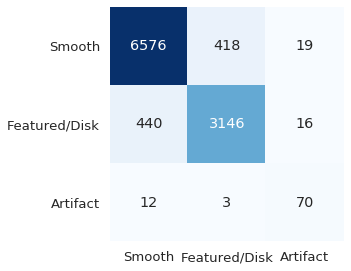

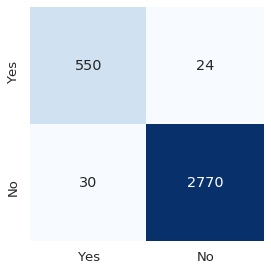

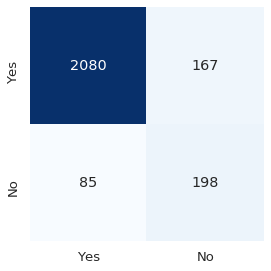

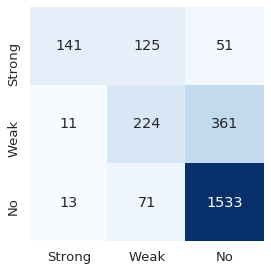

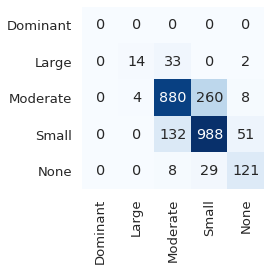

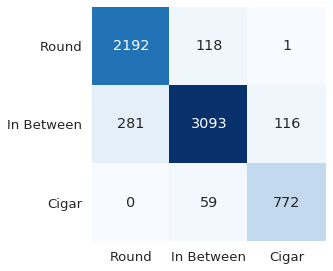

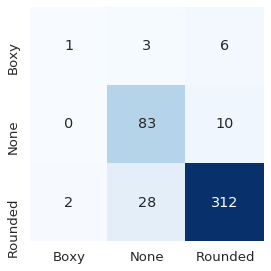

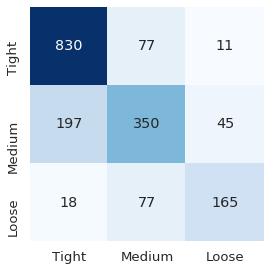

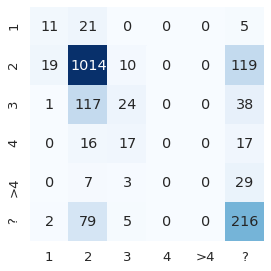

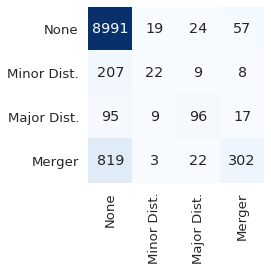

In [43]:
for question in schema.questions:
    fig = show_confusion_matrix(question, retired, predicted_fractions)
    plt.tight_layout()
#     plt.savefig('/home/walml/repos/zoobot_private/results/temp/thesis_cm_decals_dr_full_ensemble_allq_allconf_' + question.text + '.png')
#     plt.clf()  # comment to view, uncomment to save without interfering with each other

In [38]:
assert False

AssertionError: 

## Metrics for high confidence galaxies

Defining high confidence in multi-q case is harder. Perhaps, that fraction for any one answer?

In [118]:
# high_confidence = (retired[answer.text + '_fraction'] > 0.8) | (retired[answer.text + '_fraction'] < 0.2)
# print_metrics(question, retired[high_confidence], predicted_fractions[high_confidence])

# show_confusion_matrix(question, retired[high_confidence], predicted_fractions[high_confidence])

Question & Count & Accuracy & Precision & Recall & F1 \\
\hline \hline
Smooth Or Featured & 3275 & 0.9979 & 0.9979 & 0.9979 & 0.9979 \\
Disk Edge On & 3087 & 0.9974 & 0.9974 & 0.9974 & 0.9974 \\
Has Spiral Arms & 1803 & 0.9700 & 0.9810 & 0.9700 & 0.9736 \\


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


Bar & 465 & 0.9849 & 0.9914 & 0.9849 & 0.9878 \\
Bulge Size & 211 & 0.9716 & 0.9716 & 0.9716 & 0.9715 \\
How Rounded & 3692 & 0.9913 & 0.9914 & 0.9913 & 0.9913 \\
Edge On Bulge & 229 & 0.9869 & 0.9873 & 0.9869 & 0.9870 \\
Spiral Winding & 180 & 0.9889 & 1.0000 & 0.9889 & 0.9943 \\
Spiral Arm Count & 577 & 0.9567 & 0.9700 & 0.9567 & 0.9614 \\


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Merging & 2967 & 0.9987 & 0.9990 & 0.9987 & 0.9988 \\


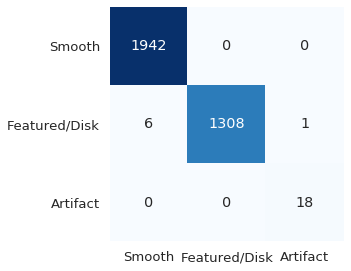

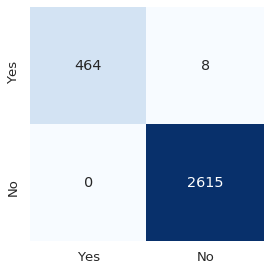

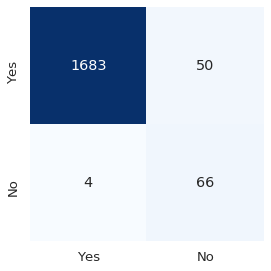

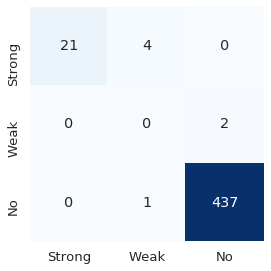

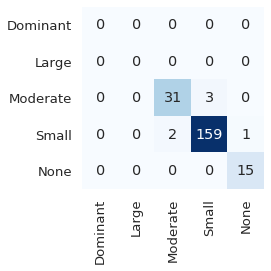

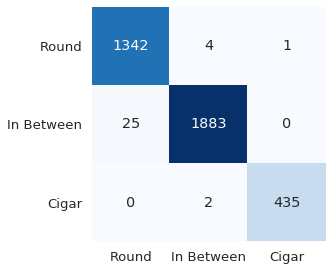

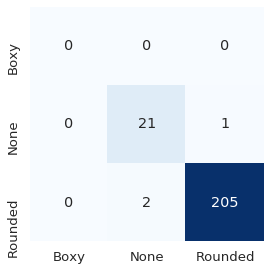

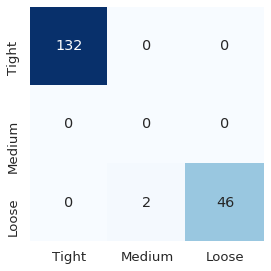

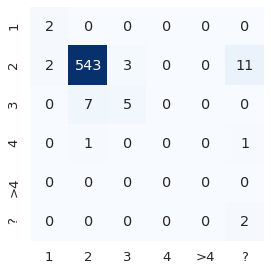

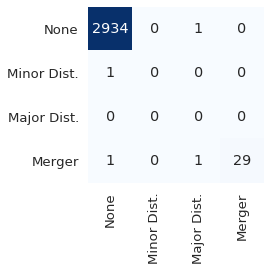

In [44]:
print(r'Question & Count & Accuracy & Precision & Recall & F1 \\')
print('\hline \hline')
for question in schema.questions:
#     if len(question.answers) == 2:
#         answer = question.answers[0]
    answers = question.answers
    fractions = np.array([retired[answer.text + '_fraction'] for answer in answers])
    high_confidence = np.any(fractions > 0.8, axis=0)
    print_metrics(question, retired[high_confidence], predicted_fractions[high_confidence])
    fig = show_confusion_matrix(question, retired[high_confidence], predicted_fractions[high_confidence])
    plt.tight_layout()
#     plt.savefig('/home/walml/repos/zoobot/results/temp/thesis_cm_decals_dr_full_ensemble_allq_highconf_' + question.text + '.png')
#     plt.clf()  # comment to view, uncomment to save without interfering with each other

In [ ]:
assert False

## Metrics for Both

In [58]:
# axd = plt.figure(constrained_layout=True).subplot_mosaic(
#     """
#     ABD
#     CCD
#     """
# )
# https://matplotlib.org/stable/tutorials/provisional/mosaic.html#sphx-glr-tutorials-provisional-mosaic-py
# not yet released

AttributeError: 'Figure' object has no attribute 'subplot_mosaic'

<Figure size 432x288 with 0 Axes>

Text(-0.5, 0.5, 'Merging')

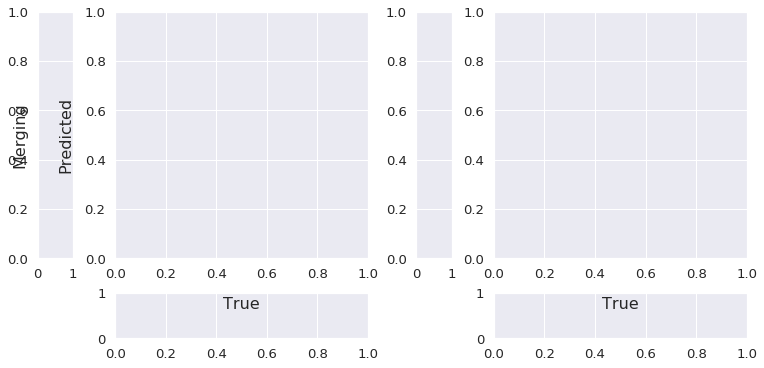

In [139]:

fig = plt.figure(constrained_layout=True, figsize=(10.5, 5))
gs = fig.add_gridspec(8, 10)

ax0 = fig.add_subplot(gs[:6, 0])
ax1 = fig.add_subplot(gs[:6, 1:5])
ax2 = fig.add_subplot(gs[:6, 6:])

ax3 = fig.add_subplot(gs[6:, 1:5])
ax4 = fig.add_subplot(gs[6:, 6:])

ax5 = fig.add_subplot(gs[:6, 5:6])

label_size = 16
ax3.text(0.5, 0.75, 'True', horizontalalignment='center', verticalalignment='center', fontsize=label_size)
ax4.text(0.5, 0.75, 'True', horizontalalignment='center', verticalalignment='center', fontsize=label_size)

ax0.text(0.8, 0.5, 'Predicted', rotation='vertical', horizontalalignment='center', verticalalignment='center', fontsize=label_size)
ax0.text(-0.5, 0.5, clean_text(question.text), rotation='vertical', horizontalalignment='center', verticalalignment='center', fontsize=label_size)


In [145]:
for question in schema.questions:
    print(question.text)
    

    fig = plt.figure(constrained_layout=True, figsize=(10.5, 5))
    gs = fig.add_gridspec(8, 10)

    ax0 = fig.add_subplot(gs[:6, 0])
    ax1 = fig.add_subplot(gs[:6, 1:5])
    ax2 = fig.add_subplot(gs[:6, 6:])

    ax3 = fig.add_subplot(gs[6:, 1:5])
    ax4 = fig.add_subplot(gs[6:, 6:])

    ax5 = fig.add_subplot(gs[:6, 5:6])
    
#     fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 10))
    fig = show_confusion_matrix(question, retired, predicted_fractions, ax=ax1)

    fractions = np.array([retired[answer.text + '_fraction'] for answer in question.answers])
    high_confidence = np.any(fractions > 0.8, axis=0)
    fig = show_confusion_matrix(question, retired[high_confidence], predicted_fractions[high_confidence], ax=ax2, blank_yticks=False)
    
    label_size = 16
    ax3.text(0.5, 0.75, 'True', horizontalalignment='center', verticalalignment='center', fontsize=label_size)
    ax4.text(0.5, 0.75, 'True', horizontalalignment='center', verticalalignment='center', fontsize=label_size)

    ax0.text(0.8, 0.5, 'Predicted', rotation='vertical', horizontalalignment='center', verticalalignment='center', fontsize=label_size)
    ax0.text(-0.5, 0.5, clean_text(question.text), rotation='vertical', horizontalalignment='center', verticalalignment='center', fontsize=label_size, weight='bold')

    for ax in [ax0, ax3, ax4, ax5]:
        ax.grid('off')
        ax.axis('off')
        
    # comment to view vs save. clf needed to not interfere with each other
    plt.savefig('/home/walml/repos/zoobot_private/results/temp/cm_decals_dr_full_ensemble_paired_' + question.text + '.png')
    plt.clf()  
    

smooth-or-featured
disk-edge-on


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


has-spiral-arms


/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


bar
bulge-size
how-rounded
edge-on-bulge
spiral-winding
spiral-arm-count
merging


<Figure size 756x360 with 0 Axes>

<Figure size 756x360 with 0 Axes>

<Figure size 756x360 with 0 Axes>

<Figure size 756x360 with 0 Axes>

<Figure size 756x360 with 0 Axes>

<Figure size 756x360 with 0 Axes>

<Figure size 756x360 with 0 Axes>

<Figure size 756x360 with 0 Axes>

<Figure size 756x360 with 0 Axes>

<Figure size 756x360 with 0 Axes>

In [35]:
for question in schema.questions:
    for answer in question.answers:
        retired[answer.text + '_ml_fraction'] = predicted_fractions[:, answer.index]

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
question = schema.get_question('spiral-arm-count')
answer = schema.get_answer('spiral-arm-count_cant-tell')

In [37]:
confused_cant_tell_arms = retired[answer.text + '_fraction'] 

In [38]:


valid_labels, valid_predictions = filter_to_sensible(retired, predicted_fractions, question)
y_true, y_pred = get_binary_responses(question, valid_labels, valid_predictions)

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [39]:
cant_tell_confused_with_two = (y_true == 5) & (y_pred == 1)
two_confused_with_cant_tell = (y_true == 1) & (y_pred == 5)

In [40]:
valid_labels[cant_tell_confused_with_two]['locations'].values[:5]

array(['["https://panoptes-uploads.zooniverse.org/production/subject_location/7d6d6cad-de5c-4243-bc1f-6b0ac0e73596.png"]',
       '["https://panoptes-uploads.zooniverse.org/production/subject_location/72ceb6be-1873-4c5e-8d42-5e3f20b6ca9b.png"]',
       '["https://panoptes-uploads.zooniverse.org/production/subject_location/e8bf70c8-32f7-4db6-a667-51d726905af3.png"]',
       '["https://panoptes-uploads.zooniverse.org/production/subject_location/14e26ad2-7250-47f1-8fa2-83ac20d75626.png"]',
       '["https://panoptes-uploads.zooniverse.org/production/subject_location/0e06788b-27e0-49b7-b703-1cbae1255774.png"]'],
      dtype=object)

In [41]:
retired['spiral-arm-count_2_ml_fraction']

1        0.909988
3        0.489325
4        0.939987
5        0.262811
6        0.491270
           ...   
49609    0.171202
49627    0.373450
49652    0.308567
49671    0.351261
49680    0.183243
Name: spiral-arm-count_2_ml_fraction, Length: 11346, dtype: float32

In [42]:
retired['spiral-arm-count_cant-tell_ml_fraction']

1        0.034408
3        0.047830
4        0.013235
5        0.280942
6        0.248969
           ...   
49609    0.587892
49627    0.377485
49652    0.247354
49671    0.421153
49680    0.445591
Name: spiral-arm-count_cant-tell_ml_fraction, Length: 11346, dtype: float32

In [43]:
# copied from trust_the_model.ipynb
def show_galaxies(df, scale=3, nrows=6, ncols=6):
    fig = plt.gcf()

    plt.figure(figsize=(scale * nrows * 1.505, scale * ncols / 2.59))
    gs1 = gridspec.GridSpec(nrows, ncols)
    gs1.update(wspace=0.0, hspace=0.0)
    galaxy_n = 0
    for row_n in range(nrows):
        for col_n in range(ncols):
            galaxy = df.iloc[galaxy_n]
            image = Image.open(galaxy['file_loc'])
            ax = plt.subplot(gs1[row_n, col_n])
            ax.imshow(image)
            ax.text(35, 50, 'Vol: 2={:.2f}, ?={:.2f}'.format(galaxy['spiral-arm-count_2_fraction'], galaxy['spiral-arm-count_cant-tell_fraction']), fontsize=12, color='r')
            ax.text(35, 100, 'ML: 2={:.2f}, ?={:.2f}'.format(galaxy['spiral-arm-count_2_ml_fraction'], galaxy['spiral-arm-count_cant-tell_ml_fraction']), fontsize=12, color='r')
#             ax.text(10, 50, r'$\rho = {:.2f}$, Var ${:.3f}$'.format(galaxy['median_prediction'], 3*galaxy['predictions_var']), fontsize=12, color='r')
#             ax.text(10, 80, '$L = {:.2f}$'.format(galaxy['bcnn_likelihood']), fontsize=12, color='r')
            ax.axis('off')
            galaxy_n += 1
#     print('Mean L: {:.2f}'.format(df[:nrows * ncols]['bcnn_likelihood'].mean()))
    fig = plt.gcf()
    fig.tight_layout()
    return fig


In [44]:
_ = show_galaxies(valid_labels[cant_tell_confused_with_two].sample(8), nrows=2, ncols=4)

PermissionError: [Errno 13] Permission denied: '/media/walml/beta/decals/png_native/dr5/J130/J130836.21-022016.2.png'

<Figure size 432x288 with 0 Axes>

<Figure size 650.16x333.591 with 0 Axes>

In [45]:
_ = show_galaxies(valid_labels[two_confused_with_cant_tell].sample(8), nrows=2, ncols=4)

PermissionError: [Errno 13] Permission denied: '/media/walml/beta/decals/png_native/dr5/J123/J123209.35+113307.3.png'

<Figure size 432x288 with 0 Axes>

<Figure size 650.16x333.591 with 0 Axes>

# Regression Metrics

In [ ]:
errors = []
min_total_votes = 20
for question_n, question in enumerate(schema.questions):
    for answer in question.answers:
        print(question.text, answer.text)
        valid_labels, valid_predictions = filter_to_sensible(retired, predicted_fractions, question)  # df, np.array
        valid_labels.reset_index()
        enough_votes = valid_labels[question.text + '_total-votes'] >= min_total_votes  # not quite the same as filter_to_sensible
        y_true = valid_labels.loc[enough_votes, answer.text + '_fraction']
        y_pred = valid_predictions[enough_votes, answer.index]
        assert not pd.isna(y_true).any()
        assert not pd.isna(y_pred).any()
        absolute = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        errors.append({'answer': answer.text, 'rmse': np.sqrt(mse), 'mean_absolute_error': absolute, 'question_n': question_n})

metrics = pd.DataFrame(errors)


In [ ]:
colorbrewer = [
    '#8dd3c7',
    '#ffffb3',
    '#bebada',
    '#fb8072',
    '#80b1d3',
    '#fdb462',
    '#b3de69',
    '#fccde5',
    '#d9d9d9',
    '#bc80bd'
]
base_palette = sns.color_palette(colorbrewer)


In [ ]:
# base_palette = sns.husl_palette(len(schema.questions))
# base_palette = sns.choose_colorbrewer_palette('qualitative')

# import random
# random.shuffle(base_palette)
# sns.palplot(base_palette)

In [ ]:
repeating_palette = []
for q_n, question in enumerate(schema.questions):
    for a_n, answer in enumerate(question.answers):
        repeating_palette.append(base_palette[q_n])

In [ ]:
sns.set_style('whitegrid', {'axes.edgecolor': '0.2'})
sns.set_context('notebook')
sns.set_palette(repeating_palette)
fig, ax = plt.subplots(figsize=(6, 8))
sns.barplot(data=metrics, y='answer', x='mean_absolute_error', ax=ax)
plt.xlabel('Vote Fraction Mean Deviation')
plt.ylabel('')
fig.tight_layout()
# plt.savefig('mean_deviation_bar.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data=metrics, y='answer', x='rmse', ax=ax)

In [ ]:

# question = schema.get_question('has-spiral-arms')
answer = schema.get_answer('bulge-size_moderate')
question = answer.question
# answer = question.answers[0]
valid_labels, valid_predictions = filter_to_sensible(retired, predicted_fractions, question)
sns.scatterplot(valid_labels[answer.text + '_fraction'], valid_predictions[:, answer.index], alpha=.1)



In [ ]:
plt.hist(valid_labels[question.text + '_total-votes'], bins=40, range=(0, 60))

In [ ]:
question.asked_after

In [ ]:
valid_labels.iloc[np.argsort(valid_labels[question.text + '_total-votes'])[:10]]['smooth-or-featured_featured-or-disk_fraction']

In [ ]:
plt.hist(valid_labels[answer.text + '_fraction'], bins=40)

In [ ]:
valid_labels['smooth-or-featured_total-votes'].hist(bins=30, range=[0., 120])

In [ ]:

fig, axes = plt.subplots(nrows=len(label_cols), figsize=(8, len(label_cols) * 3))
ax_n = 0
for question in schema.questions:
    valid_labels, valid_predictions = filter_to_sensible(retired, predicted_fractions, question)
    for answer in question.answers:
        sns.scatterplot(valid_labels[answer.text + '_fraction'], valid_predictions[:, answer.index], ax=axes[ax_n], alpha=.14)
        ax_n += 1


In [ ]:
retired['smooth-or-featured_total-votes'].hist(bins=30)

In [ ]:
is_intense = retired['smooth-or-featured_total-votes'] > 75
intense_labels, intense_predictions = retired[is_intense], predicted_fractions[is_intense]

In [ ]:
def mimic_fewer(galaxy, question):
    data = []
    n_answers = len(question.answers)
    actual_votes = galaxy[[a.text for a in question.answers]].values
    actual_fractions = actual_votes / actual_votes.sum()
    total_votes = actual_votes.sum()
    
    removed_votes = 0
    latest_votes = actual_votes.copy()
    while removed_votes < total_votes:
        fractions = np.array([latest_votes[answer_n]/latest_votes.sum() for answer_n in range(n_answers)])
        assert latest_votes.sum() + removed_votes == total_votes
        data.append({'n_votes': total_votes - removed_votes, 'votes': latest_votes.copy(), 'fractions': fractions, 'deviations': np.abs(fractions - actual_fractions)})
        
#         answer_above_0 = latest_votes > 0
#         valid_answer_indices = np.arange(n_answers)[answer_above_0]
#         index_to_reduce = np.random.choice(valid_answer_indices)
        index_to_reduce = np.random.choice(np.arange(n_answers), p=fractions)
        latest_votes[index_to_reduce] = latest_votes[index_to_reduce] - 1
        removed_votes += 1
        
    return data
            

In [ ]:
question = schema.get_question('smooth-or-featured')
# question = schema.get_question('has-spiral-arms')
# question = schema.get_question('bar')
# question = schema.get_question('bulge-size')
galaxy = intense_labels.sample().squeeze()
mimic = pd.DataFrame(data=mimic_fewer(galaxy, question))

# sns.set()
# n_votes = mimic['n_votes']
# fractions = np.stack(mimic['fractions'], axis=0)
# for answer_n, answer in enumerate(question.answers):
#     print(answer.text)
#     plt.plot(n_votes, fractions[:, answer_n], label=answer.text)
#     plt.axhline(mimic.sort_values('n_votes')['fractions'].iloc[-1][answer_n], linestyle='--', color='k', alpha=.5)
# plt.legend()

In [ ]:
# mimic['deviations']

In [ ]:
# sns.set()
# deviations = np.stack(mimic['deviations'], axis=0)
# n_votes = mimic['n_votes']
# for answer_n, answer in enumerate(question.answers):
#     print(answer.text)
#     plt.plot(n_votes, deviations[:, answer_n], label=answer.text)
# plt.legend()

In [ ]:
deviations

In [ ]:
data = []
valid_intense, _ = filter_to_sensible(intense_labels, intense_predictions, question)
# print(len(valid_intense))
for n_votes in np.arange(1, 40):
    print(n_votes)
    all_deviations = []
    for _, galaxy in valid_intense.iterrows():
        mimic = pd.DataFrame(data=mimic_fewer(galaxy, question))
        deviations = mimic.query(f'n_votes == {n_votes}')['deviations'].squeeze()
        assert len(deviations) > 0
#         assert deviations.shape == (len(question.answers),)
        all_deviations.append(deviations)
    all_deviations = np.stack(all_deviations, axis=0)
    mean_abs = all_deviations.mean(axis=0)
    result = {'n_votes': n_votes}
    result.update(dict(zip([a.text for a in question.answers], mean_abs)))
    data.append(result)

In [ ]:
deviation_df = pd.DataFrame(data=data)

In [ ]:
def convert_to_label(x):
    return x.replace(question.text, '').replace('_', '').capitalize()

In [ ]:
# colors = sns.color_palette('mako', 5)
# colors = sns.color_palette('mako')
# colors = base_palette

# colorbrewer = [
#     '#8dd3c7',
#     '#ffffb3',
#     '#bebada',
#     '#fb8072',
#     '#80b1d3',
#     '#fdb462',
#     '#b3de69',
#     '#fccde5',
#     '#d9d9d9',
#     '#bc80bd'
# ]
# colors = sns.color_palette(colorbrewer[-5:])


In [ ]:
# prob_of_answers = np.expand_dims(galaxy[[a.text + '_fraction' for a in schema.answers]], axis=0)
# galaxy['smooth-or-featured_featured-or-disk_fraction']                         
# deviation_df['n_votes_total'] = deviation_df['n_votes'] / schema.joint_p(prob_of_answers, question.asked_after.text)  # looks more impressive, but is maybe a level of complexity too far - not used

In [ ]:
sns.set_context('notebook')
sns.set(font_scale=1.3, style='whitegrid', rc={'grid.linewidth': .5})  # softening the grid lines

colors = sns.color_palette('deep', len(question.answers))
# colors = ['y', 'b', 'g', 'r', 't']

for a_n, a in enumerate(question.answers):

    # exclude 'dominant' for bulge, rare  question.answers[1:]
    # exclude no for spiral, no need      if a_n == 0:
    sns.lineplot(data=deviation_df, x='n_votes', y=a.text, color=colors[a_n], label=convert_to_label(a.text), marker='.', markersize=10.)
    plt.axhline(metrics.query(f'answer == "{a.text}"').squeeze()['mean_absolute_error'], color=colors[a_n], linestyle='--')
plt.legend()
plt.ylabel('Mean error vs. all votes')
plt.xlabel('Truncated number of votes')
# if question.text == 'smooth-or-featured':
plt.xlim([0, 20])
plt.ylim(0., .25)
# if question.text == 'bulge-size':
#     plt.xlim([0, 20])
#     plt.ylim(0., .25)
plt.title(question.text.replace('-', ' ').title())  # .title = capitalize each word (isn't python <3)
plt.tight_layout()
plt.savefig('notebooks/multiq/performance/vs_all_votes_' + question.text + '.png')
plt.savefig('notebooks/multiq/performance/vs_all_votes_' + question.text + '.pdf')